In [1]:
# Cell 1 (Corrected and Complete)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

# --- ADD THESE TWO MISSING LINES ---
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
# -----------------------------------

def rotation_x(theta):
    """Returns the 4x4 transformation matrix for a rotation about the X-axis."""
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([
        [1, 0, 0, 0],
        [0, c, -s, 0],
        [0, s, c, 0],
        [0, 0, 0, 1]
    ])

def rotation_y(theta):
    """Returns the 4x4 transformation matrix for a rotation about the Y-axis."""
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([
        [c, 0, s, 0],
        [0, 1, 0, 0],
        [-s, 0, c, 0],
        [0, 0, 0, 1]
    ])

def rotation_z(theta):
    """Returns the 4x4 transformation matrix for a rotation about the Z-axis."""
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([
        [c, -s, 0, 0],
        [s, c, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

def translation(x, y, z):
    """Returns the 4x4 transformation matrix for a translation."""
    return np.array([
        [1, 0, 0, x],
        [0, 1, 0, y],
        [0, 0, 1, z],
        [0, 0, 0, 1]
    ])

print("Helper functions for transformations are defined (with animation imports).")

Helper functions for transformations are defined (with animation imports).


In [2]:
# Cell 2: Forward Kinematics Function

def forward_kinematics_3d(thetas, links):
    """
    Calculates the 3D position of each joint of the arm.
    thetas = [theta1, theta2, theta3] in radians
    links = [L1, L2]
    """
    theta1, theta2, theta3 = thetas
    L1, L2 = links
    
    # We start at the origin (0,0,0) with no rotation
    T = np.identity(4)
    
    # Position of Joint 1 (Base) is always at the origin
    p0 = T[:3, 3]

    # Transformation for Joint 2 (Shoulder)
    T_0_1 = T @ rotation_z(theta1) @ rotation_y(theta2)
    
    # Transformation to the end of Link 1 (Elbow)
    T_0_2 = T_0_1 @ translation(0, 0, L1) # Note: We model links along their local Z-axis for simplicity
    p1 = T_0_2[:3, 3]

    # Transformation to the end of Link 2 (Hand)
    T_0_3 = T_0_2 @ rotation_y(theta3) @ translation(0, 0, L2)
    p2 = T_0_3[:3, 3]
    
    return p0, p1, p2

print("Forward kinematics function defined.")

Forward kinematics function defined.


Base Position (P0): [0. 0. 0.]
Elbow Position (P1): [0.35355339 0.35355339 0.8660254 ]
Hand Position (P2): [1.03656609 1.03656609 1.12484445]


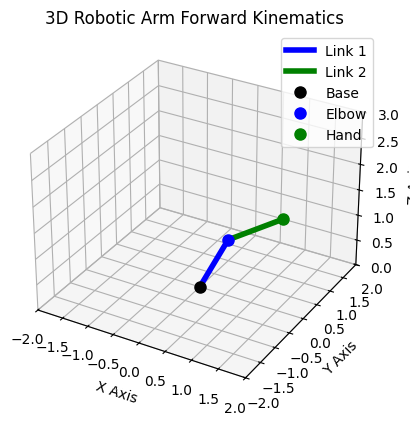

In [3]:
# Cell 3: Test and Visualize the Forward Kinematics

# --- Define Arm and Angles ---
link_lengths = [1.0, 1.0] # L1, L2

# Angles in degrees (easier to think about)
angles_deg = [45, 30, 45] # theta1, theta2, theta3
# Convert to radians for calculation
angles_rad = np.deg2rad(angles_deg)

# --- Calculate Joint Positions ---
p0, p1, p2 = forward_kinematics_3d(angles_rad, link_lengths)

print(f"Base Position (P0): {p0}")
print(f"Elbow Position (P1): {p1}")
print(f"Hand Position (P2): {p2}")

# --- Plotting ---
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the links of the arm
ax.plot([p0[0], p1[0]], [p0[1], p1[1]], [p0[2], p1[2]], 'b-', lw=4, label='Link 1')
ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 'g-', lw=4, label='Link 2')

# Plot the joints
ax.plot([p0[0]], [p0[1]], [p0[2]], 'o', color='black', markersize=8, label='Base')
ax.plot([p1[0]], [p1[1]], [p1[2]], 'o', color='blue', markersize=8, label='Elbow')
ax.plot([p2[0]], [p2[1]], [p2[2]], 'o', color='green', markersize=8, label='Hand')

# Setting labels and limits for clarity
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('3D Robotic Arm Forward Kinematics')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([0, 3])
ax.legend()
plt.show()

In [4]:
# Cell 4: The Error Function for the Optimizer

def error_function(thetas, target_pos, links):
    """
    Calculates the distance between the current hand position and the target.
    This is the function we will ask the optimizer to minimize.
    """
    # Calculate the current position of the hand
    p0, p1, p2 = forward_kinematics_3d(thetas, links)
    current_pos = p2
    
    # Calculate the Euclidean distance (error)
    error = np.linalg.norm(current_pos - target_pos)
    
    return error

print("Error function for optimization defined.")

Error function for optimization defined.


In [5]:
# Cell 5: The Inverse Kinematics Solver

def inverse_kinematics_3d(target_pos, links):
    """
    Finds the joint angles to reach a target position using numerical optimization.
    """
    # Initial guess for the angles
    initial_guess = np.array([0.0, 0.0, 0.0])

    # We can set bounds for each joint angle (in radians) to make it more realistic
    # Here, we allow full rotation for base, and -180 to +180 for shoulder/elbow
    bounds = [(-np.pi, np.pi), (-np.pi, np.pi), (-np.pi, np.pi)]

    # Call the optimizer
    # It will try to minimize 'error_function' by changing the angles in 'initial_guess'
    result = minimize(
        error_function,
        initial_guess,
        args=(target_pos, links), # Additional arguments to pass to the error function
        method='SLSQP',
        bounds=bounds
    )

    # Return the optimized angles
    if result.success:
        return result.x
    else:
        # Sometimes the optimizer fails to find a solution
        print(f"Inverse kinematics failed: {result.message}")
        return None

print("Inverse kinematics solver defined.")

Inverse kinematics solver defined.


In [6]:
# Cell 6: Test Drive the Inverse Kinematics

# --- Define a Target ---
target_position = np.array([0.5, 0.8, 1.2])
link_lengths = [1.0, 1.0] # L1, L2

print(f"Target Position: {target_position}\n")

# --- Solve for Joint Angles ---
print("Solving for inverse kinematics...")
optimal_angles_rad = inverse_kinematics_3d(target_position, link_lengths)

if optimal_angles_rad is not None:
    print(f"\nOptimal Angles (radians): {optimal_angles_rad}")
    print(f"Optimal Angles (degrees): {np.rad2deg(optimal_angles_rad)}")

    # --- Verification Step ---
    print("\n--- Verification ---")
    print("Plugging the calculated angles back into forward kinematics...")
    p0, p1, p2 = forward_kinematics_3d(optimal_angles_rad, link_lengths)
    final_hand_position = p2

    print(f"Target Hand Position:    {target_position}")
    print(f"Calculated Hand Position: {final_hand_position}")
    
    error = np.linalg.norm(target_position - final_hand_position)
    print(f"Final Error: {error}")

    # You can also re-run the plotting code from Cell 3 with the new optimal angles
    # to see the arm reaching for the target.

Target Position: [0.5 0.8 1.2]

Solving for inverse kinematics...

Optimal Angles (radians): [ 1.01219881 -0.03627212  1.40503943]
Optimal Angles (degrees): [57.99471956 -2.07823963 80.5028294 ]

--- Verification ---
Plugging the calculated angles back into forward kinematics...
Target Hand Position:    [0.5 0.8 1.2]
Calculated Hand Position: [0.49999813 0.80000019 1.19999973]
Final Error: 1.9023406668490287e-06


In [7]:
# Final Cell (Updated to save MP4)

# We need this to display the animation video in the notebook
%matplotlib inline
from IPython.display import HTML

# --- 1. Define Trajectory (Code from before - no changes needed) ---
start_pos_3d = np.array([1.5, 0.5, 0.5])
end_pos_3d = np.array([-0.5, -0.8, 1.5])
link_lengths = [1.0, 1.0]
num_points = 100 # Number of points in the trajectory

x_path = np.linspace(start_pos_3d[0], end_pos_3d[0], num_points)
y_path = np.linspace(start_pos_3d[1], end_pos_3d[1], num_points)
z_path = np.linspace(start_pos_3d[2], end_pos_3d[2], num_points)
cartesian_path = np.vstack([x_path, y_path, z_path]).T

# --- 2. Solve IK for each point in the trajectory (Code from before - no changes needed) ---
print("Planning trajectory by solving IK for each point...")
trajectory_angles = []
for i, point in enumerate(cartesian_path):
    print(f"Solving for point {i+1}/{num_points}...", end='\r')
    angles = inverse_kinematics_3d(point, link_lengths)
    if angles is not None:
        trajectory_angles.append(angles)
print("\nTrajectory planned successfully!")

# --- 3. Animate the result (Code from before - no changes needed) ---
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

line, = ax.plot([], [], [], 'o-', lw=4, color='#0066CC')
ax.plot(x_path, y_path, z_path, 'r--', label='Planned Path')
ax.plot([end_pos_3d[0]], [end_pos_3d[1]], [end_pos_3d[2]], 'x', color='red', markersize=10, label='Target')

def init():
    line.set_data_3d([], [], [])
    return line,

def animate(i):
    thetas = trajectory_angles[i]
    p0, p1, p2 = forward_kinematics_3d(thetas, link_lengths)
    line.set_data_3d([p0[0], p1[0], p2[0]], [p0[1], p1[1], p2[1]], [p0[2], p1[2], p2[2]])
    return line,

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('3D Robotic Arm Trajectory')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([0, 3])
ax.legend()

ani = FuncAnimation(fig, animate, frames=len(trajectory_angles),
                    init_func=init, blit=True, interval=50)


# --- THIS IS THE NEW PART ---

# 4. Save the animation as an MP4 file
print("\nSaving animation as an MP4... This may take a moment.")
ani.save('3d_arm_trajectory.mp4', writer='ffmpeg', fps=30)
print("MP4 file saved successfully!")

# 5. Display the animation in the notebook as before
display(HTML(ani.to_html5_video()))
plt.close()

Planning trajectory by solving IK for each point...
Solving for point 75/100...

C:\Users\USER\Documents\Anaconda\envs\house-price-predictor\lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Solving for point 100/100...
Trajectory planned successfully!

Saving animation as an MP4... This may take a moment.
MP4 file saved successfully!
